In [2]:
%reload_ext autoreload
%autoreload 2

In [30]:
from ripple_heterogeneity.utils import (
    functions,
    loading,
    compress_repeated_epochs,
    batch_analysis,
    add_new_deep_sup,
    custom_plots
)
from ripple_heterogeneity.replay import replay_run, replay_fig, replay_participation
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import os
import pickle
import seaborn as sns
import nelpy as nel
from nelpy.analysis import replay
import random
from matplotlib.ticker import AutoMinorLocator
import copy

In [4]:
functions.set_plotting_defaults()
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
fig_save_path = r'Z:\home\ryanh\projects\ripple_heterogeneity\figures\panels'

In [6]:
save_path = r'Z:\home\ryanh\projects\ripple_heterogeneity\replay_v7'
# save_path = r'Z:\home\ryanh\projects\ripple_heterogeneity\replay'

df = replay_run.load_results(save_path,pre_task_post=True)

In [123]:
def leave_one_out_score(results, direction, idx_replay):
    """
    Leave one out score for a given direction.
    Inputs:
        results: dict of results from replay_run.run_replay
        direction: string, 'inbound_epochs' or 'outbound_epochs'
    Outputs:
        score: float, score (cell x replay) for the given direction
    """
    scores = []
    units = np.array(results[direction]["bst_placecells"].series_ids).T
    for i in units:

        bst = copy.deepcopy(results[direction]["bst_placecells"])
        tc = copy.deepcopy(results[direction]["tc"])

        tc = tc._unit_subset(units[units != i])
        bst = bst._unit_subset(units[units != i])

        scores.append(
            replay.trajectory_score_bst(
                bst[idx_replay], tc, w=3, n_shuffles=0, normalize=True
            )
        )
    return np.array(scores)


def get_leave_one_out_score(results, direction):
    # locate significant replay events
    idx_replay = np.where(results[direction]["df"].score_pval_time_swap < 0.05)[0]
    # find observed score for each replay event
    obs_scores = replay.trajectory_score_bst(
        results[direction]["bst_placecells"][idx_replay],
        results[direction]["tc"],
        w=3,
        n_shuffles=0,
        normalize=True,
    )
    # find score for each replay event and leave one cell out for each replay
    scores = leave_one_out_score(results, direction, idx_replay)
    avg_left_out_score = (scores - obs_scores).mean(axis=1)

    return avg_left_out_score


results_df = pd.DataFrame()
for basepath in df.basepath.unique():
    # locate saved replay file and load it
    save_file = os.path.join(
        save_path, basepath.replace(os.sep, "_").replace(":", "_") + ".pkl"
    )

    with open(save_file, "rb") as f:
        results = pickle.load(f)
    if results is None:
        continue
    for direction in ["inbound_epochs", "outbound_epochs"]:
        temp_df = pd.DataFrame()
        
        temp_df["avg_left_out_score"] = get_leave_one_out_score(results, direction)

        bst.n_active_per_bin 
        

        cell_metrics = results[direction]["cell_metrics"]
        temp_df["UID"] = cell_metrics.UID.values
        temp_df["deepSuperficialDistance"] = cell_metrics.deepSuperficialDistance.values
        temp_df["deepSuperficial"] = cell_metrics.deepSuperficial.values
        temp_df["direction"] = direction
        temp_df["basepath"] = basepath
        results_df = pd.concat([results_df, temp_df], ignore_index=True)


In [124]:
results_df = add_new_deep_sup.deep_sup_from_deepSuperficialDistance(results_df)
results_df

,avg_left_out_score,UID,deepSuperficialDistance,deepSuperficial,direction,basepath
0,-0.018951,7,-40.000000,Deep,inbound_epochs,Z:\Data\GrosmarkAD\Achilles\Achilles_10252013
1,-0.014622,12,0.000000,middle,inbound_epochs,Z:\Data\GrosmarkAD\Achilles\Achilles_10252013
2,-0.017777,16,40.000000,Superficial,inbound_epochs,Z:\Data\GrosmarkAD\Achilles\Achilles_10252013
3,-0.008267,23,-60.000000,Deep,inbound_epochs,Z:\Data\GrosmarkAD\Achilles\Achilles_10252013
4,-0.027845,26,-60.000000,Deep,inbound_epochs,Z:\Data\GrosmarkAD\Achilles\Achilles_10252013
...,...,...,...,...,...,...
691,-0.018603,73,-20.000000,middle,outbound_epochs,Z:\Data\Kenji\ec014.459_480
692,-0.048607,74,10.000000,middle,outbound_epochs,Z:\Data\Kenji\ec014.459_480
693,-0.024762,76,-30.000000,Deep,outbound_epochs,Z:\Data\Kenji\ec014.459_480
694,-0.009839,77,-40.000000,Deep,outbound_epochs,Z:\Data\Kenji\ec014.459_480


Text(0, 0.5, 'avg replay score when each unit is left out')

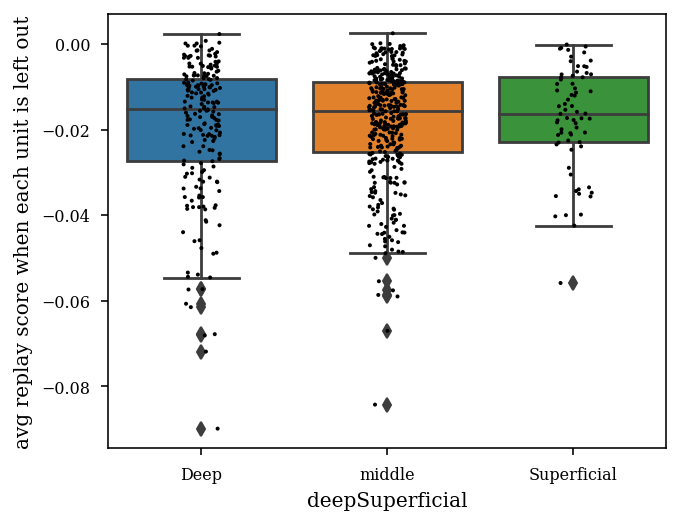

In [130]:
plt.figure(figsize=(5,4))
sns.boxplot(x="deepSuperficial", y="avg_left_out_score",
            data=results_df)

sns.stripplot(x="deepSuperficial", y="avg_left_out_score",
            data=results_df,color="k",s=2)
plt.ylabel("avg replay score when each unit is left out")

In [139]:
bst.n_active_per_bin

array([ 7, 11,  8, ..., 10,  4,  4])

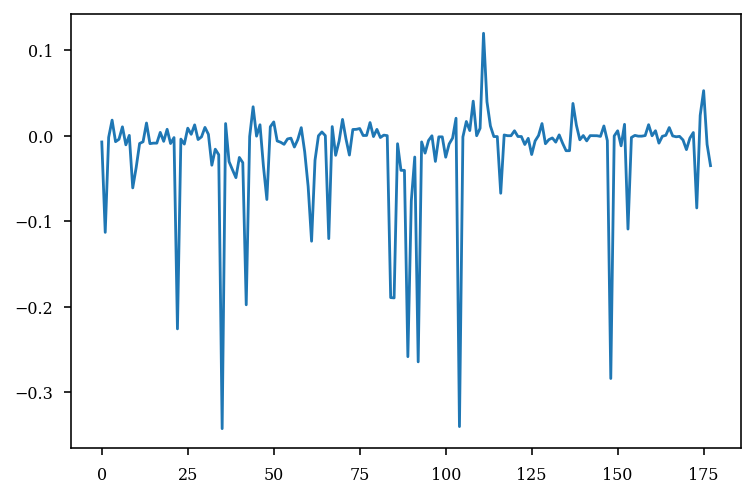

(array([ 1.,  0.,  3.,  0.,  7.,  6., 11., 11., 11., 13.]),
 array([-0.04851912, -0.04369887, -0.03887862, -0.03405837, -0.02923812,
        -0.02441787, -0.01959762, -0.01477737, -0.00995712, -0.00513687,
        -0.00031662]),
 <BarContainer object of 10 artists>)

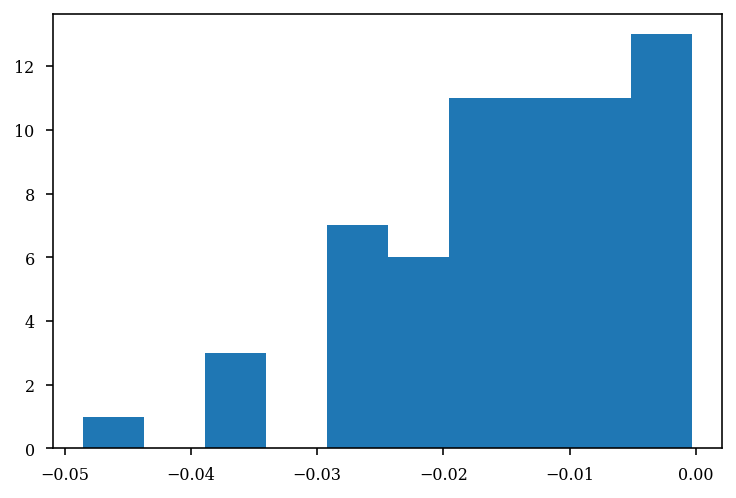

In [113]:
# sns.heatmap(np.array(scores) - obs_scores)
plt.plot((np.array(scores) - obs_scores)[9,:])
plt.show()
avg_left_out_score = (np.array(scores) - obs_scores).mean(axis=1)

plt.hist(avg_left_out_score)

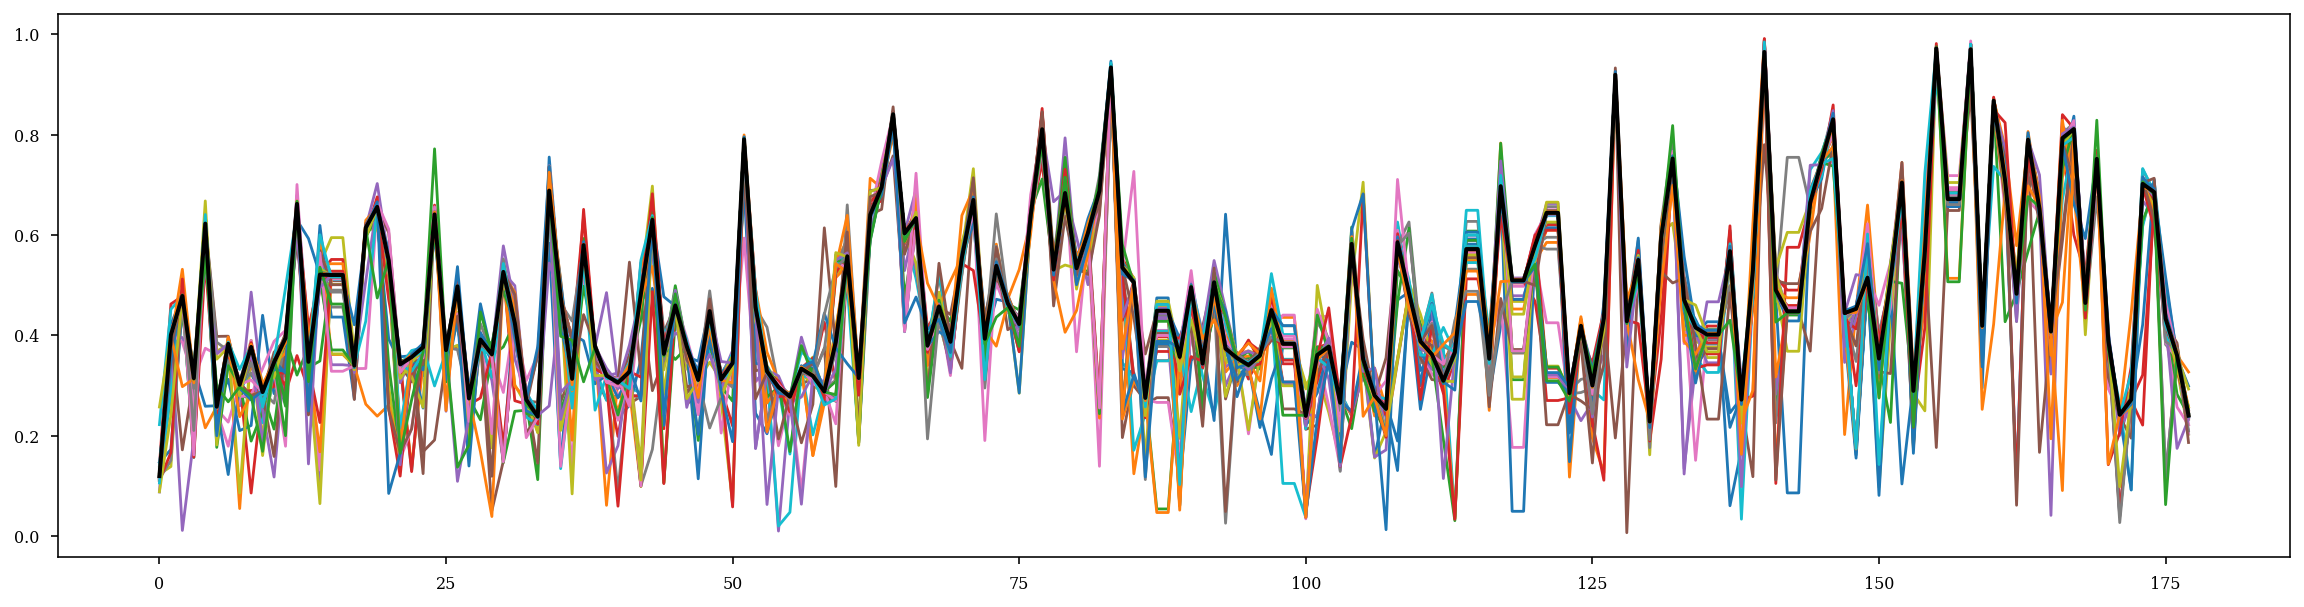

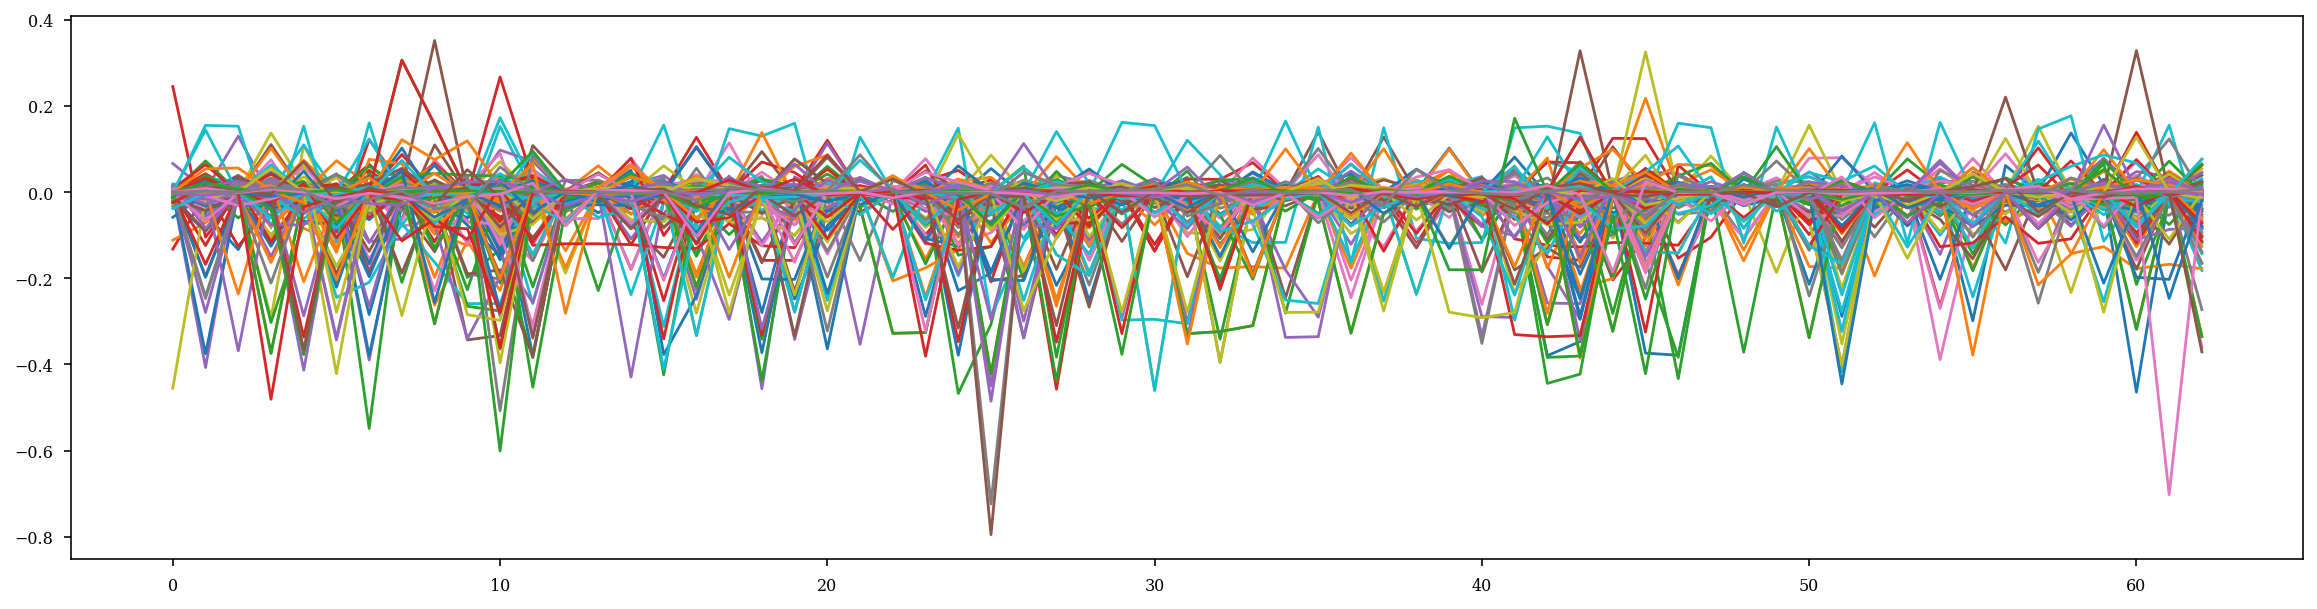

In [111]:
plt.figure(figsize=(20, 5))
plt.plot(obs_scores,color="k",linewidth=2,zorder=100)
plt.plot(np.array(scores).T)
plt.show()

plt.figure(figsize=(20, 5))
plt.plot(np.array(scores) - obs_scores)
plt.show()

In [56]:
bst = copy.deepcopy(results["outbound_epochs"]["bst_placecells"])
tc = copy.deepcopy(results["outbound_epochs"]["tc"])
tc,bst

(<TuningCurve1D at 0x164785a9040> with shape (63, 53),
 <BinnedSpikeTrainArray at 0x164785a9490: 63 series (2,295 segments) in 10,541 bins of width 20.0 milliseconds> for a total of 3:30:820 minutes)

In [61]:
units = np.arange(bst.n_active) + 1
units[units != i]

array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
       36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52,
       53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63])

In [57]:
# bst = bst._unit_subset(unit_ids_to_keep)
# tc = tc._unit_subset(unit_ids_to_keep)
tc._unit_subset(np.arange(1,bst.n_active))

<TuningCurve1D at 0x164785a9160> with shape (22, 53)

In [50]:
tc._ratemap = tc.ratemap[1:,:]
tc

<TuningCurve1D at 0x164785a9820> with shape (62, 53)

In [46]:
bst._data = bst.data[1:,:]
bst.data.shape

(62, 10541)

In [36]:
posteriors, bdries, mode_pth, mean_pth = nel.decoding.decode1D(
        results['outbound_epochs']['bst_placecells'][idx_replay],
        results['outbound_epochs']['tc'],
        xmin=np.nanmin(results['outbound_epochs']['pos'].data),
        xmax=np.nanmax(results['outbound_epochs']['pos'].data),
    )                                        
scores = replay.trajectory_score_bst(
    results['outbound_epochs']['bst_placecells'][idx_replay], results['outbound_epochs']['tc'], w=3, n_shuffles=0, normalize=True
    )
scores

array([0.11949161, 0.4006972 , 0.47853975, 0.31476137, 0.62269588,
       0.2578765 , 0.38321765, 0.30154744, 0.37694903, 0.28701763,
       0.34622618, 0.39461997, 0.66200715, 0.34725828, 0.52110006,
       0.52024497, 0.52024497, 0.33987687, 0.61473299, 0.65600746,
       0.54934355, 0.34209759, 0.35669666, 0.37638889, 0.64112176,
       0.37060476, 0.49772293, 0.27442669, 0.39169534, 0.36227183,
       0.52645904, 0.42456405, 0.27193   , 0.23790288, 0.68847884,
       0.47718473, 0.31338106, 0.57990549, 0.37752564, 0.31970985,
       0.30570927, 0.32743916, 0.48314554, 0.63020338, 0.36312097,
       0.45963352, 0.37801373, 0.31113997, 0.44841791, 0.31250908,
       0.34489415, 0.79096161, 0.4558363 , 0.32833093, 0.2968456 ,
       0.2777172 , 0.33360617, 0.31927688, 0.28821467, 0.38723403,
       0.55738616, 0.31488295, 0.64019811, 0.69539379, 0.84061351,
       0.60330965, 0.63359003, 0.37976788, 0.45755305, 0.3871162 ,
       0.55475177, 0.66989562, 0.39339455, 0.53861614, 0.46391

In [17]:
results[replay.direction].keys()

idx = np.where((results['outbound_epochs']['df'].score_pval_time_swap < 0.05) &
                (results['outbound_epochs']['df'].replay_type == 'forward'))[0]

dict_keys(['cell_metrics', 'sta_placecells', 'bst_placecells', 'bst_run', 'pos', 'tc', 'posteriors', 'bdries', 'mode_pth', 'position', 'df', 'session', 'decoding_r2', 'decoding_r2_pval', 'decoding_median_error', 'total_units'])

In [14]:
sig_replays,

results.keys()

dict_keys(['outbound_epochs', 'inbound_epochs'])